## 1. 데이터 준비

In [1]:
%matplotlib inline
# Standard library imports
import datetime
from datetime import datetime
import os
from copy import deepcopy
import pickle

# Third-party libraries imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytz
import seaborn as sns
import random
from itertools import combinations

# from IPython.display import clear_output
from scipy.spatial import distance
from sklearn.decomposition import PCA

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, Subset
from torchvision import datasets, transforms

# Local application/library specific imports
from data_utils import (generate_server_idcs, CustomSubset, split_3class_unbalanced, split_contain_multiclass,
                        split_7plus3class_unbalanced, CombinedCustomSubset)
from fl_devices import Server, Client
from helper import ExperimentLogger, display_train_stats
from models import ConvNet, Representation, Ten_class_classifier, Four_class_classifier


torch.manual_seed(42)
np.random.seed(42)

In [2]:
LOCAL_EPOCHS = 25
N_CLIENTS = 6
NUMBER_OF_CLUSTER = 3
ALPHA = 0.1
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# data = datasets.CIFAR10(root="CIFAR10/", download=True)
data = datasets.MNIST(root="MNIST/", download=False)
idcs = np.random.permutation(len(data))

def cluster(server, clients, number_of_cluster):
    label_predicted = pd.DataFrame()
    # label_acc = pd.DataFrame()
    for i, client in enumerate(clients):
        pred = server.check_cluster(client.model)
        # print(f'pred: {pred}')
        label_predicted = pd.concat([label_predicted, pd.DataFrame(pred, index=[i])])
        # label_acc = pd.concat([label_acc, pd.DataFrame(acc, index=[i])])
    label_predicted.reset_index(drop=True, inplace=True)
    label_predicted.fillna(0, inplace=True)
    
    print(f'predicted label')
    print(label_predicted)

    cluster_idcs, number_of_cluster= server.cluster_clients(label_predicted)
    return label_predicted, cluster_idcs, number_of_cluster



def get_cluster_averages(df, cluster_idcs):
    cluster_averages = {}

    for i, cluster in enumerate(cluster_idcs):
        cluster_data = df.loc[cluster, :]
        cluster_average = cluster_data.mean()
        cluster_averages[i] = cluster_average

    cluster_averages_df = pd.DataFrame(cluster_averages).T

    # calculate percentage for each value in a row
    cluster_percentages_df = cluster_averages_df.div(cluster_averages_df.sum(axis=1), axis=0).multiply(100)

    # apply threshold and rounding
    cluster_percentages_df = cluster_percentages_df.where(cluster_percentages_df >= 5, 0).round()

    return cluster_percentages_df / 10


def get_cluster_weights(cluster_logits, cluster_weight_per_class):
    # Step 1: Find the class with the maximum value in each logit in cluster_logits
    # Assuming the dimension for classes is the second one
    max_classes = [torch.argmax(logit, dim=1) for logit in cluster_logits]
    
    print(max_classes)
    cluster_weights = []
    #c luster별로 
    for i, iogits in enumerate(cluster_logits):
        weights = []
        for j, logit in enumerate(logits):
            
            # print(f'max_classes: {max_classes[i][j]}')
            # print("Shape of cluster_weight_per_class[{}]: ".format(i), cluster_weight_per_class[i].shape)
            weights.append(max_classes[i][j])
        print(weights)
        cluster_weights.append(weights)

def visualize_clusters(label_predicted, real_cluster_distribution):
    # Reduce the dimension of the data
    pca = PCA(n_components=2)
    label_predicted_pca = pca.fit_transform(label_predicted)
    
    # Define colors for the clusters
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

    # Calculate the number of samples in each real cluster
    n_samples = len(label_predicted)
    real_cluster_sizes = [int(n_samples * dist) for dist in real_cluster_distribution]

    # Plot the clusters
    plt.figure(figsize=(8, 5))

    start_idx = 0  # To keep track of the start index of each real cluster
    for i, size in enumerate(real_cluster_sizes):
        end_idx = start_idx + size  # Calculate the end index for this real cluster
        color = colors[i % len(colors)]  # Determine the color for this real cluster

        # Scatter plot for points belonging to this real cluster
        for j in range(start_idx, end_idx):
            plt.scatter(label_predicted_pca[j, 0], label_predicted_pca[j, 1], c=color, s=50, label=f'Group {i+1}' if j == start_idx else "")

        start_idx = end_idx  # Update the start index for the next real cluster
    
    # Remove duplicate labels in legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), fontsize='xx-large')

    # Remove x and y ticks
    plt.xticks([])
    plt.yticks([])

    # Save the figure with narrow margins
    plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01)
    current_time = datetime.now().strftime('%Y%m%d%H%M%S')
    plt.savefig(f'Figures/cluster_visualization_{current_time}.png', dpi=300, format='png')

    
    plt.show()



#     # Print the real cluster distribution
#     print("Real cluster distribution:", real_cluster_distribution)

#     # Calculate and print each client's cluster identity based on the real_cluster_distribution
#     n_clients = len(label_predicted)
#     cumulative_distribution = [0] + [sum(real_cluster_distribution[:i+1]) for i in range(len(real_cluster_distribution))]
#     client_cluster_id_real = [next((i for i, val in enumerate(cumulative_distribution) if val > client_idx / n_clients), -1) - 1 for client_idx in range(n_clients)]

#     print("Real cluster identity for each client:", client_cluster_id_real)

#     # Print each client's cluster identity based on the clusters argument
#     client_cluster_id_predicted = [next((i for i, cluster in enumerate(clusters) if client_idx in cluster), -1) for client_idx in range(n_clients)]
#     print("Predicted cluster identity for each client:", client_cluster_id_predicted)




def test_acc(server, clients, cluster_distribution):
    
    # Get individual client accuracies
    acc_clients = [client.evaluate() for client in clients]

    # Compute the average accuracy for each client
    client_acc = round(sum(acc_clients) / len(acc_clients), 3) if len(acc_clients) > 0 else 0

    # Compute cluster accuracies for this iteration
    cluster_accs_iteration = []
    start_idx = 0
    for distribution in cluster_distribution:
        end_idx = start_idx + int(distribution * len(clients))
        cluster_acc = round(sum(acc_clients[start_idx:end_idx]) / (end_idx - start_idx) + 0.000001, 3)
        cluster_accs_iteration.append(cluster_acc)
        start_idx = end_idx

    # Compute global accuracy for this iteration
    accuracies = [server.evaluate_distil(client.classifier) for client in clients]
    global_acc = round(np.mean(accuracies), 3)
    
    return client_acc, cluster_accs_iteration, global_acc


def get_global_logits(client_logits):
    avg_logits = torch.mean(torch.stack(client_logits), dim=0)
    return avg_logits

# def get_cluster_logits(client_logits, cluster_idcs):
#     cluster_logits = []
#     for i, cluster in enumerate(cluster_idcs):
#         cluster_client_logits = [client_logits[i] for i in cluster]
#         avg_cluster_logits = torch.mean(torch.stack(cluster_client_logits), dim=0)
#         cluster_logits.append(avg_cluster_logits)
#     return cluster_logits


def get_cluster_averages(df, cluster_idcs):
    cluster_averages = {}

    for i, cluster in enumerate(cluster_idcs):
        cluster_data = df.loc[cluster, :]
        cluster_average = cluster_data.mean()
        cluster_averages[i] = cluster_average

    cluster_averages_df = pd.DataFrame(cluster_averages).T

    # calculate percentage for each value in a row
    cluster_percentages_df = cluster_averages_df.div(cluster_averages_df.sum(axis=1), axis=0).multiply(100)

    # apply threshold and rounding
    cluster_percentages_df = cluster_percentages_df.where(cluster_percentages_df >= 5, 0).round()

    return cluster_percentages_df / 10

def compute_accuracy(global_logits, data_targets, server_idcs):
    """
    Compute accuracy of predictions based on global logits.

    Args:
    - global_logits (list of Tensors): Each Tensor represents the logits for a data instance, 
                                       and its size is the number of classes.
    - data_targets (list of ints): List of true labels for all data.
    - server_idcs (list of ints): Indices of data instances we're interested in.

    Returns:
    - accuracy (float): Computed accuracy.
    """
    true_labels = [data_targets[i] for i in server_idcs]
    
    correct_predictions = 0
    total_predictions = len(true_labels)

    for logits, label in zip(global_logits, true_labels):
        predicted_label = np.argmax(logits.cpu().numpy())  # Convert Tensor to numpy and get index of max value
        if predicted_label == label:
            correct_predictions += 1

    accuracy = correct_predictions / total_predictions
    return accuracy


def save_tensor_to_csv(tensor, filename):
    # Convert tensor to numpy array
    array = tensor.cpu().detach().numpy()
    
    # Save numpy array to CSV file
    np.savetxt(filename, array, delimiter=",")

# def get_cluster_weights(cluster_logits, cluster_weight_per_class):
#     # Step 1: Find the class with the maximum value in each logit in cluster_logits
#     # Assuming the dimension for classes is the second one
#     max_classes = [torch.argmax(logit, dim=1) for logit in cluster_logits]
    
#     print(max_classes)
#     cluster_weights = []
#     #c luster별로 
#     for i, iogits in enumerate(cluster_logits):
#         weights = []
#         for j, logit in enumerate(logits):
            
#             # print(f'max_classes: {max_classes[i][j]}')
#             # print("Shape of cluster_weight_per_class[{}]: ".format(i), cluster_weight_per_class[i].shape)
#             weights.append(max_classes[i][j])
#         print(weights)
#         cluster_weights.append(weights)


In [4]:
def make_global_logit(n_clients, total_client_data, distill_data, number_of_cluster, cluster_distribution, instance_per_class, instances_per_class_per_client):
    data_per_class=int(distill_data//10)
    train_idcs, test_idcs = idcs[:total_client_data], idcs[total_client_data:(total_client_data + int(distill_data * 2))]
    train_labels = data.targets
    test_labels = data.targets
    server_idcs = generate_server_idcs(test_idcs, test_labels, int(distill_data//10))
    print(f'sever idcs: {len(server_idcs)}')
    #client_idcs, _ = split_7plus3class_unbalanced(train_idcs, train_labels, n_clients, cluster_distribution, instance_per_class, instance_per_minor_class)
    client_idcs = split_contain_multiclass(train_idcs, train_labels, n_clients, instance_per_class, instances_per_class_per_client, cluster_distribution)
    
    client_data = [CustomSubset(data, idcs) for idcs in client_idcs]
    test_data = CustomSubset(data, server_idcs, transforms.Compose([transforms.ToTensor()]))
    print(f'test_data: {len(test_data)}')
    
    for i, client_datum in enumerate(client_data):
        client_datum.subset_transform = transforms.Compose([transforms.ToTensor()])

    server = Server(ConvNet, lambda x : torch.optim.Adam(x),test_data)

    clients = [Client(Representation, dat, i) 
           for i, dat in enumerate(client_data) if len(dat) > 20]
    
    # print(f'client count: {len(clients)}')

    client_logits = []
    
        
    # 1. Train classifier
    for i, client in enumerate(clients):
        client.classifier = Ten_class_classifier(client.model).to(device)
        client.train_classifier(lr=1e-3)

    client_acc, cluster_accs, global_acc = test_acc(server, clients, cluster_distribution)
    
    # 2. get client loigt
    for i, client in enumerate(clients):
        client_logits.append(server.get_clients_logit(client.classifier))

    # 3. make global logit
    global_logits = server.get_global_logits(client_logits)
    accuracy = compute_accuracy(global_logits, test_labels, server_idcs)
    
    print(f"Global Logit's Accuracy: {accuracy * 100:.2f}%")
    
    return server, clients, client_logits, global_logits, number_of_cluster, server_idcs, cluster_distribution, client_acc, cluster_accs, global_acc

def distill_with_cluster_logit(server, clients, client_logits, global_logits, number_of_cluster, server_idcs, cluster_distribution, t):
    cluster_logits,  cluster_idcs, label_predicted = server.get_cluster_logits(client_logits, number_of_cluster, t)
    visualize_clusters(label_predicted, cluster_distribution)
    silhouette, ari = server.evaluate_clustering(label_predicted, cluster_distribution, cluster_idcs)
    
    print(f'silhouette: {silhouette}, ari: {ari}')

    cluster_distill_loaders = []
    
    for cluster_logit in cluster_logits:
        distill_loader = server.create_distill_loader(data, server_idcs, cluster_logit)
        cluster_distill_loaders.append(distill_loader)
        
    for i, client in enumerate(clients):
        if i % 10 == 0:
            print(f'client {i} distill')
        
        cluster_idx = next(j for j, cluster in enumerate(cluster_idcs) if i in cluster)
        
        client.distill((cluster_distill_loaders[cluster_idx]))
    
    client_acc, cluster_accs, global_acc = test_acc(server, clients, cluster_distribution)
    
    return client_acc, cluster_accs, global_acc, silhouette, ari


def get_cluster_acc(server, clients, client_logits, global_logits, number_of_cluster, server_idcs, cluster_distribution, t):
    cluster_logits,  cluster_idcs, label_predicted = server.get_cluster_logits(client_logits, number_of_cluster, t)
    visualize_clusters(label_predicted, cluster_distribution)
    silhouette, ari = server.evaluate_clustering(label_predicted, cluster_distribution, cluster_idcs)
    
    print(f'silhouette: {silhouette}, ari: {ari}')
    return silhouette, ari


def distill_with_global_logit(server, clients, client_logits, global_logits, number_of_cluster, server_idcs, cluster_distribution):
    distill_loader = server.create_distill_loader(data, server_idcs, global_logits)
    
    for i, client in enumerate(clients):
        if i % 10 == 0:
            print(f'client {i} distill')
        client.distill(distill_loader)
    
    client_acc, cluster_accs, global_acc = test_acc(server, clients, cluster_distribution)
    
    return client_acc, cluster_accs, global_acc

def copy_classifiers(clients):
    classifiers_state = []
    for client in clients:
        classifier_state = client.classifier.state_dict()
        classifiers_state.append(classifier_state)
    return classifiers_state


In [5]:
def cluster_train_result_exp(n_clients, total_client_data, distill_data, number_of_cluster, cluster_distribution, instance_per_class, instances_per_class_per_client, t):
   
    client_accs = []
    cluster_accs = []
    global_accs = []
    
    (
        server, clients, client_logits, global_logits,
        number_of_cluster, server_idcs, cluster_distribution,
        new_client_acc, new_cluster_accs, new_global_acc
    ) = make_global_logit(
        n_clients, total_client_data, distill_data,
        number_of_cluster, cluster_distribution,
        instance_per_class, instances_per_class_per_client
    )

    
    print(f'acc before distill: {new_client_acc}, {new_cluster_accs}, {new_global_acc}')
    client_accs.append(new_client_acc)
    cluster_accs.append(new_cluster_accs)
    global_accs.append(new_global_acc)

    classifiers_state = copy_classifiers(clients)
    
    new_client_acc, new_cluster_accs, new_global_acc, silhouette, ari = distill_with_cluster_logit(server, clients, client_logits, global_logits, number_of_cluster, server_idcs, cluster_distribution, t)
    
    
    for i, client in enumerate(clients):
        client.classifier.load_state_dict(classifiers_state[i])
    
    client_accs.append(new_client_acc)
    cluster_accs.append(new_cluster_accs)
    global_accs.append(new_global_acc)
    
    new_client_acc, new_cluster_accs, new_global_acc = distill_with_global_logit(server, clients, client_logits, global_logits, number_of_cluster, server_idcs, cluster_distribution)
   
    
    client_accs.append(new_client_acc)
    cluster_accs.append(new_cluster_accs)
    global_accs.append(new_global_acc)
    
    print(f'acc after global distill: {client_accs[1]}, {cluster_accs[1]}, {global_accs[1]}')
    print(f'acc after cluster distill: {client_accs[-1]}, {cluster_accs[-1]}, {global_accs[-1]}')
    return client_accs, cluster_accs, global_accs, silhouette, ari

def clustering_exp(n_clients, total_client_data, distill_data, number_of_cluster, cluster_distribution, instance_per_class, instance_per_minor_class, instances_per_class_per_client, t):
   
    client_accs = []
    cluster_accs = []
    global_accs = []
    
    (
        server, clients, client_logits, global_logits,
        number_of_cluster, server_idcs, cluster_distribution,
        new_client_acc, new_cluster_accs, new_global_acc
    ) = make_global_logit(
        n_clients, total_client_data, distill_data,
        number_of_cluster, cluster_distribution,
        instance_per_class, instance_per_minor_class, instances_per_class_per_client
    )

    
    print(f'acc before distill: {new_client_acc}, {new_cluster_accs}, {new_global_acc}')
    client_accs.append(new_client_acc)
    cluster_accs.append(new_cluster_accs)
    global_accs.append(new_global_acc)

    classifiers_state = copy_classifiers(clients)
    
    sil, ari = get_cluster_acc(server, clients, client_logits, global_logits, number_of_cluster, server_idcs, cluster_distribution, t)
    return sil, ari


def get_combination(array_length, class_per_cluster):
    if class_per_cluster == 1:
        combinations = [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]]
    elif class_per_cluster == 2:
        combinations = [[0,1], [2,3], [4,5], [6,7], [8,9], [0,5], [1,6], [2,7], [3,8], [4,9], [0,3], [1,4], [2,5], [6,8], [7,9], [0,4], [1,5], [2,9], [3,7], [8,6]]
    elif class_per_cluster == 3:
        combinations = [[0,1,2], [3,4,5], [6,7,8], [9,0,1], [2,3,4], [5,6,7], [8,9,0], [1,2,3], [4,5,6], [7,8,9]]
    elif class_per_cluster == 4:
        combinations = [[0,1,2,3],[4,5,6,7],[8,9,0,1],[2,3,4,5],[6,7,8,9],[2,4,6,8],[1,3,5,9],[0,3,6,9],[1,4,7,0],[2,5,8,1]]
    elif class_per_cluster == 5:
        combinations = [[0,1,2,3,4],[4,5,6,7,8],[8,9,0,1,2],[2,3,4,5,6],[6,7,8,9,0],[2,4,6,8,0],[1,3,5,7,9],[0,2,3,6,9],[1,4,6,7,0],[2,5,6,8,1]]
    else:
        return "Invalid class_per_cluster"
    
    return combinations[:array_length]


In [6]:
def model_clustering_exp(n_clients, total_client_data, distill_data, number_of_cluster, cluster_distribution, instance_per_class, instances_per_class_per_client):
    print(f'number_of_cluster: {number_of_cluster}')
    data_per_class=int(distill_data//10)
    train_idcs, test_idcs = idcs[:total_client_data], idcs[total_client_data:(total_client_data + int(distill_data * 2))]
    train_labels = data.targets
    test_labels = data.targets
    
    server_idcs = generate_server_idcs(test_idcs, test_labels, int(distill_data//10))

    # client_idcs = split_noniid(train_idcs, train_labels, alpha=alpha, n_clients=N_CLIENTS)
    client_idcs = split_contain_multiclass(train_idcs, train_labels, n_clients, instance_per_class, instances_per_class_per_client)
    
    client_data = [CustomSubset(data, idcs) for idcs in client_idcs]
    test_data = CustomSubset(data, server_idcs, transforms.Compose([transforms.ToTensor()]))

    for i, client_datum in enumerate(client_data):
        client_datum.subset_transform = transforms.Compose([transforms.ToTensor()])

    server = Server(Representation, lambda x : torch.optim.Adam(x),test_data)

    clients = [Client(Representation, dat, i) for i, dat in enumerate(client_data) if len(dat) > 20]
    

    # 1. Train classifier
    for i, client in enumerate(clients):
        client.train_classifier(lr=1e-3)

    similarities = server.compute_pairwise_similarities(clients)
    # print('similarities')
    # print(type(similarities))
    # print(similarities)
    cluster_idcs = server.cluster_clients_KMeans(similarities, number_of_cluster)
    
    visualize_clusters(similarities, cluster_distribution)
    silhouette, ari = server.evaluate_clustering(similarities, cluster_distribution, cluster_idcs)
    print(f'silhouette: {silhouette}, ari: {ari}')
    return silhouette, ari

sever idcs: 4000
num_groups: 2
[0.7, 0.3]
test_data: 4000
32
Global Logit's Accuracy: 29.15%
acc before distill: 0.933, [0.96, 0.87], 0.667
S_normalized
[[0.816531   0.3869969  0.73335695 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.52598625 0.69411767 0.7220255  0.         0.         0.
  0.         0.         0.         0.        ]
 [0.34001252 0.39195046 1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.4257984  1.         0.6037535  0.         0.         0.
  0.         0.         0.         0.        ]
 [0.7507827  0.63962847 0.62606233 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.6950532  0.63405573 0.6607649  0.         0.         0.
  0.         0.         0.         0.        ]
 [0.55729496 0.8371517  0.6225212  0.         0.         0.
  0.         0.         0.         0.        ]
 [0.604258   0.36594427 0.86543906 0.         0.         0.
  0.         0.         0.         0. 

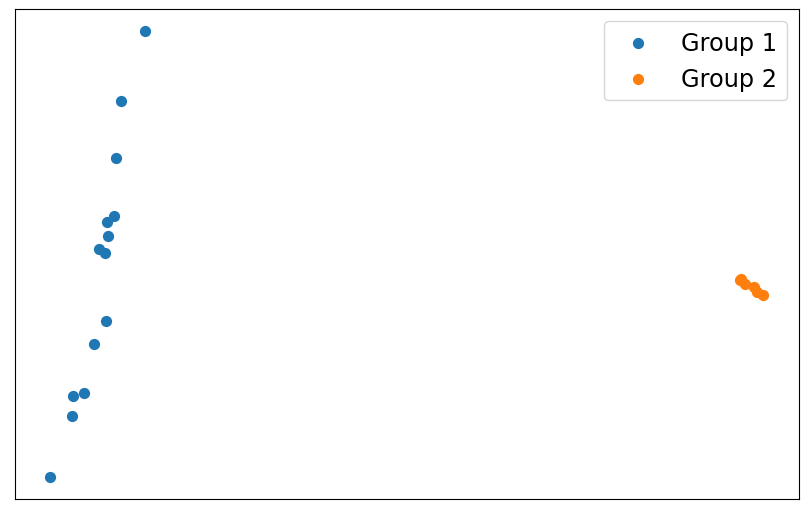

silhouette: 0.5278488993644714, ari: 0.5165394402035624
client 0 distill
client 10 distill
client 0 distill
client 10 distill
acc after global distill: 0.949, [0.967, 0.907], 0.678
acc after cluster distill: 0.673, [0.962, 0.0], 0.972
sever idcs: 4000
num_groups: 2
[0.8, 0.2]
test_data: 4000
32
Global Logit's Accuracy: 29.12%
acc before distill: 0.941, [0.964, 0.85], 0.77
S_normalized
[[0.89686334 0.63144165 0.5043119  0.         0.         0.
  0.         0.         0.         0.        ]
 [0.39393938 0.38617092 0.99999994 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.5220627  0.4722766  0.86014247 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.7373737  0.5896934  0.6407949  0.         0.         0.
  0.         0.         0.         0.        ]
 [0.43753323 0.60730594 0.8421447  0.         0.         0.
  0.         0.         0.         0.        ]
 [0.75279105 0.5988259  0.6246719  0.         0.         0.
  0.         0.  

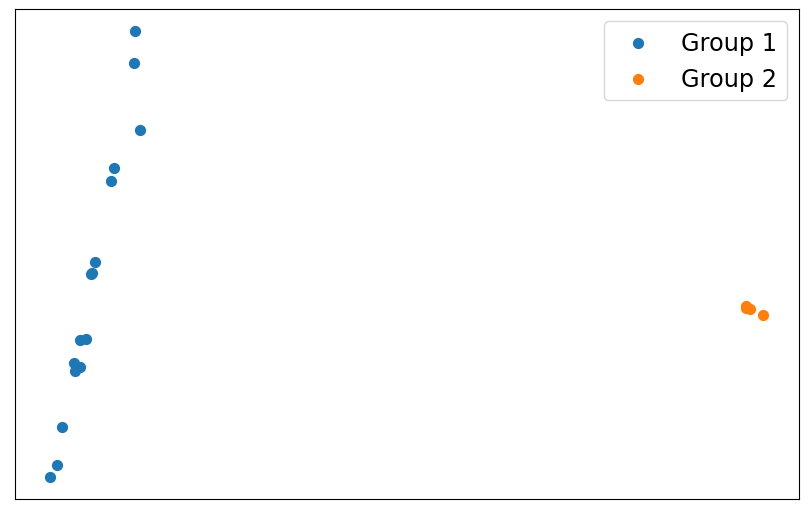

silhouette: 0.5049277544021606, ari: 0.39490445859872614
client 0 distill
client 10 distill
client 0 distill
client 10 distill
acc after global distill: 0.944, [0.968, 0.85], 0.775
acc after cluster distill: 0.776, [0.969, 0.0], 0.975
sever idcs: 4000
num_groups: 3
[0.5, 0.3, 0.2]
test_data: 4000
32
Global Logit's Accuracy: 29.10%
acc before distill: 0.927, [0.947, 0.87, 0.961], 0.476
S_normalized
[[0.475344   0.53238094 0.9969466  0.         0.         0.
  0.         0.         0.         0.        ]
 [0.46387613 1.         0.81717557 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.33715594 0.7542857  1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.456422   0.61904764 0.97480917 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.47190365 0.68666667 0.9374046  0.         0.         0.
  0.         0.         0.         0.        ]
 [0.5579128  0.68095237 0.8824428  0.         0.         0.
  0.

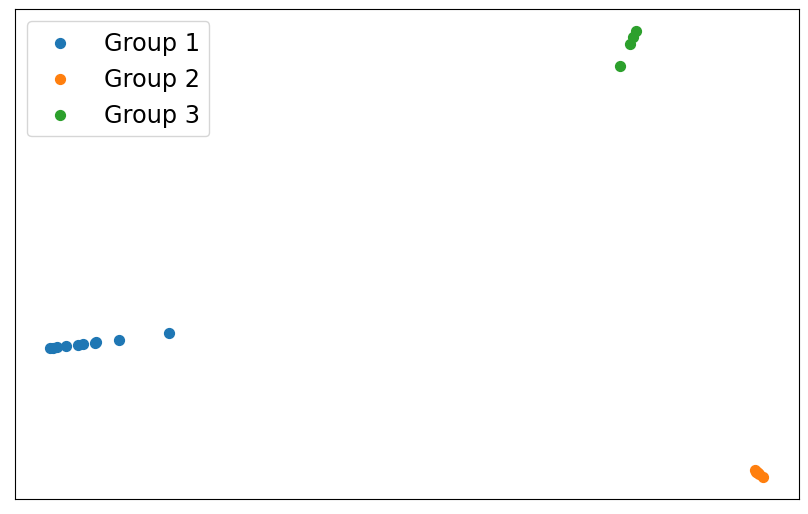

silhouette: 0.8025572896003723, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
acc after global distill: 0.941, [0.967, 0.893, 0.95], 0.482
acc after cluster distill: 0.482, [0.964, 0.0, 0.0], 0.965
sever idcs: 4000
num_groups: 3
[0.6, 0.2, 0.2]
test_data: 4000
32
Global Logit's Accuracy: 29.18%
acc before distill: 0.933, [0.957, 0.878, 0.917], 0.578
S_normalized
[[0.9271873  0.6256983  0.69159275 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.7304756  0.8762969  0.7004647  0.         0.         0.
  0.         0.         0.         0.        ]
 [0.41456252 0.7398244  1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.6200822  0.69273746 0.8770596  0.         0.         0.
  0.         0.         0.         0.        ]
 [0.628303   0.8124501  0.8077736  0.         0.         0.
  0.         0.         0.         0.        ]
 [0.78684676 0.7118915  0.74693704 0.         0.         0.
  0.   

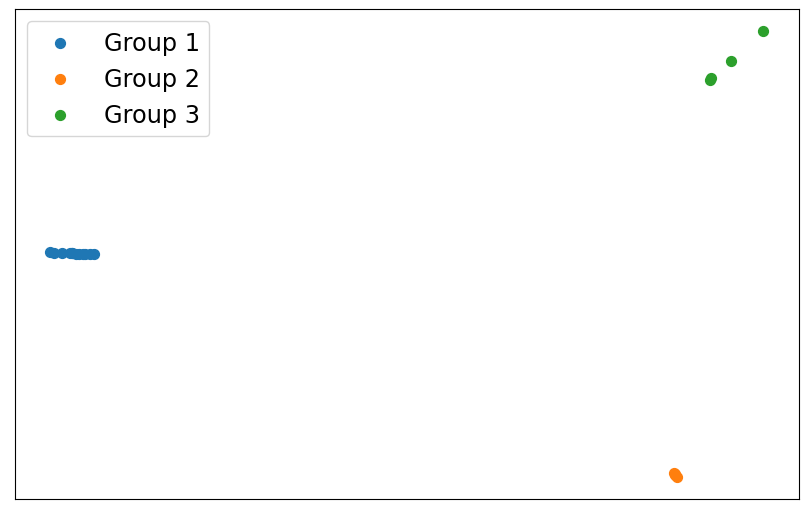

silhouette: 0.8268968462944031, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
acc after global distill: 0.947, [0.965, 0.911, 0.928], 0.587
acc after cluster distill: 0.579, [0.965, 0.0, 0.0], 0.978
sever idcs: 4000
num_groups: 4
[0.4, 0.3, 0.2, 0.1]
test_data: 4000
32
Global Logit's Accuracy: 31.92%
acc before distill: 0.909, [0.95, 0.826, 0.922, 0.967], 0.473
S_normalized
[[0.8795918  0.55580866 0.7634325  0.         0.         0.
  0.         0.         0.         0.        ]
 [0.5020408  0.83599085 0.8353305  0.         0.         0.
  0.         0.         0.         0.        ]
 [0.68299323 0.8071374  0.7471975  0.         0.         0.
  0.         0.         0.         0.        ]
 [0.81836736 0.8094153  0.66911477 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.5176871  0.49506453 0.99999994 0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.55201215 0.69694626 0.         0.       

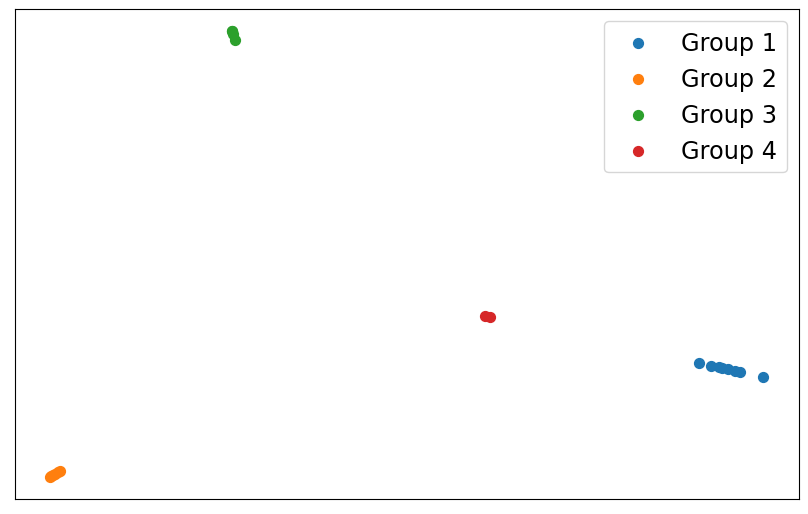

silhouette: 0.7361240983009338, ari: 0.8855421686746988
client 0 distill
client 10 distill
client 0 distill
client 10 distill
acc after global distill: 0.928, [0.956, 0.863, 0.95, 0.967], 0.474
acc after cluster distill: 0.486, [0.958, 0.096, 0.044, 0.644], 0.977
sever idcs: 4000
num_groups: 4
[0.5, 0.2, 0.2, 0.1]
test_data: 4000
32
Global Logit's Accuracy: 28.88%
acc before distill: 0.921, [0.936, 0.906, 0.878, 0.967], 0.562
S_normalized
[[0.76245654 0.5877514  0.76242065 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.46987253 0.94332725 0.80575275 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.4142526  0.5804388  0.9899141  0.         0.         0.
  0.         0.         0.         0.        ]
 [0.40150636 0.8555759  0.88569295 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.69235224 0.81261426 0.71572655 0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.9643510

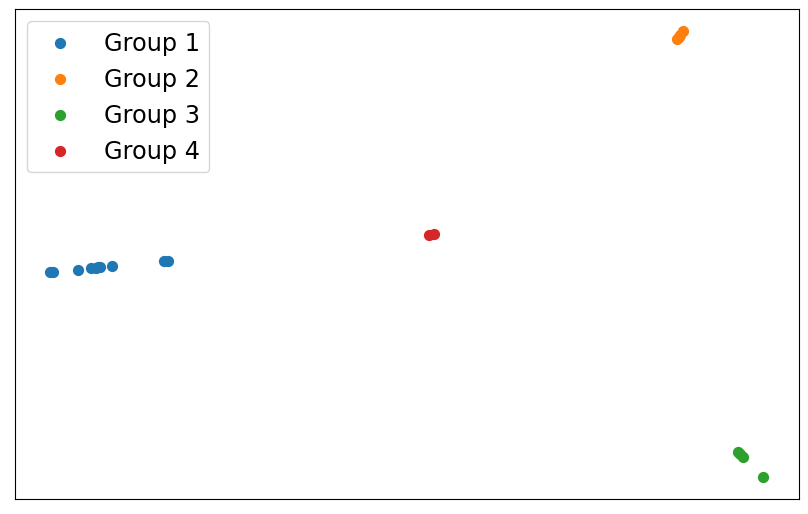

silhouette: 0.7127722501754761, ari: 0.7848244620611552
client 0 distill
client 10 distill
client 0 distill
client 10 distill
acc after global distill: 0.939, [0.953, 0.922, 0.911, 0.956], 0.569
acc after cluster distill: 0.54, [0.949, 0.0, 0.0, 0.656], 0.975
sever idcs: 4000
num_groups: 2
[0.7, 0.3]
test_data: 4000
32
Global Logit's Accuracy: 29.25%
acc before distill: 0.928, [0.957, 0.859], 0.674
S_normalized
[[0.75895244 0.54256165 0.8145923  0.         0.         0.
  0.         0.         0.         0.        ]
 [0.62373066 0.84327763 0.7609442  0.         0.         0.
  0.         0.         0.         0.        ]
 [0.40566543 1.         0.8515022  0.         0.         0.
  0.         0.         0.         0.        ]
 [0.454837   0.73031026 0.95751077 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.56921434 0.5648369  0.9549356  0.         0.         0.
  0.         0.         0.         0.        ]
 [0.6408338  0.884646   0.72489274 0.         0.  

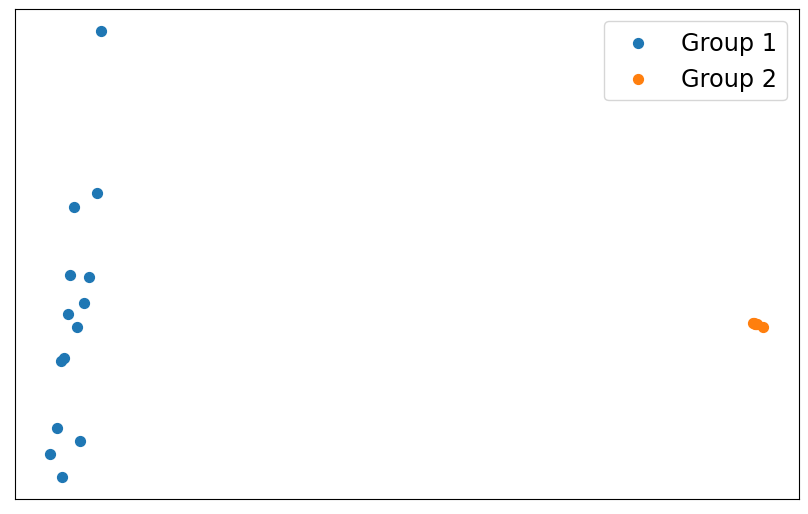

silhouette: 0.8377319574356079, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
acc after global distill: 0.951, [0.97, 0.907], 0.685
acc after cluster distill: 0.679, [0.97, 0.0], 0.976
sever idcs: 4000
num_groups: 2
[0.8, 0.2]
test_data: 4000
32
Global Logit's Accuracy: 29.07%
acc before distill: 0.934, [0.957, 0.844], 0.767
S_normalized
[[0.78186816 0.9379845  0.5515197  0.         0.         0.
  0.         0.         0.         0.        ]
 [0.49450552 0.76313525 0.8206079  0.         0.         0.
  0.         0.         0.         0.        ]
 [0.4065934  0.8062016  0.86137885 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.5263736  0.9586564  0.7149741  0.         0.         0.
  0.         0.         0.         0.        ]
 [0.5648352  0.59776056 0.8443292  0.         0.         0.
  0.         0.         0.         0.        ]
 [0.5928572  0.5331611  0.85322464 0.         0.         0.
  0.         0.         0.      

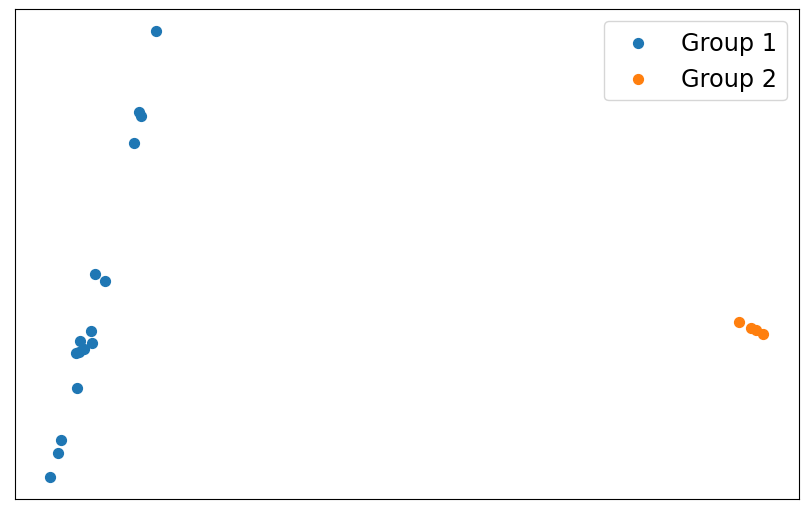

silhouette: 0.7704008221626282, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
acc after global distill: 0.95, [0.967, 0.883], 0.777
acc after cluster distill: 0.774, [0.968, 0.0], 0.971
sever idcs: 4000
num_groups: 3
[0.5, 0.3, 0.2]
test_data: 4000
32
Global Logit's Accuracy: 29.15%
acc before distill: 0.912, [0.944, 0.859, 0.911], 0.479
S_normalized
[[0.8962199  0.42875648 0.71644944 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.46597937 1.         0.62627685 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.36838487 0.40479273 1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.5450172  0.75       0.72173303 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.7353952  0.5123057  0.7534343  0.         0.         0.
  0.         0.         0.         0.        ]
 [0.89347076 0.50906736 0.67418104 0.         0.         0.
  0.         0.    

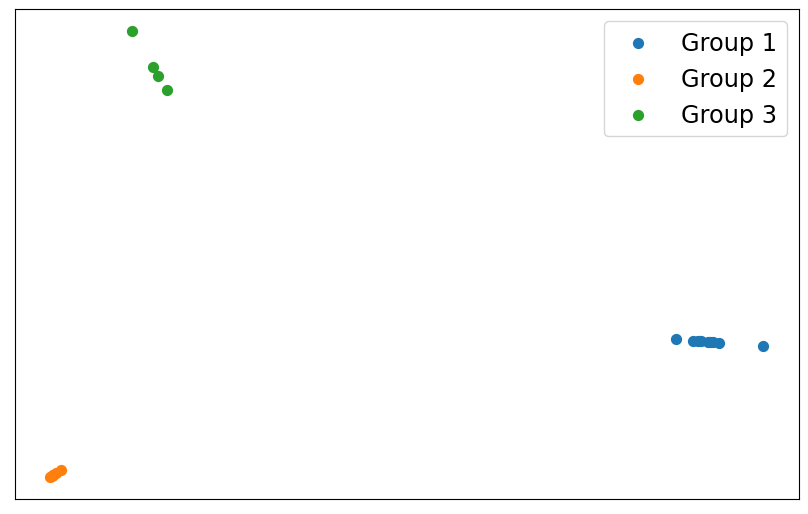

silhouette: 0.8136266469955444, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
acc after global distill: 0.934, [0.962, 0.904, 0.911], 0.484
acc after cluster distill: 0.489, [0.971, 0.011, 0.0], 0.97
sever idcs: 4000
num_groups: 3
[0.6, 0.2, 0.2]
test_data: 4000
32
Global Logit's Accuracy: 29.18%
acc before distill: 0.934, [0.957, 0.9, 0.9], 0.578
S_normalized
[[0.4021834  0.8641115  0.89494    0.         0.         0.
  0.         0.         0.         0.        ]
 [0.61572057 0.684669   0.7735849  0.         0.         0.
  0.         0.         0.         0.        ]
 [0.43231443 0.73867595 0.92710125 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.4026201  0.6498258  1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.41746727 0.8719512  0.87607205 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.45414847 0.64721256 0.95068616 0.         0.         0.
  0.     

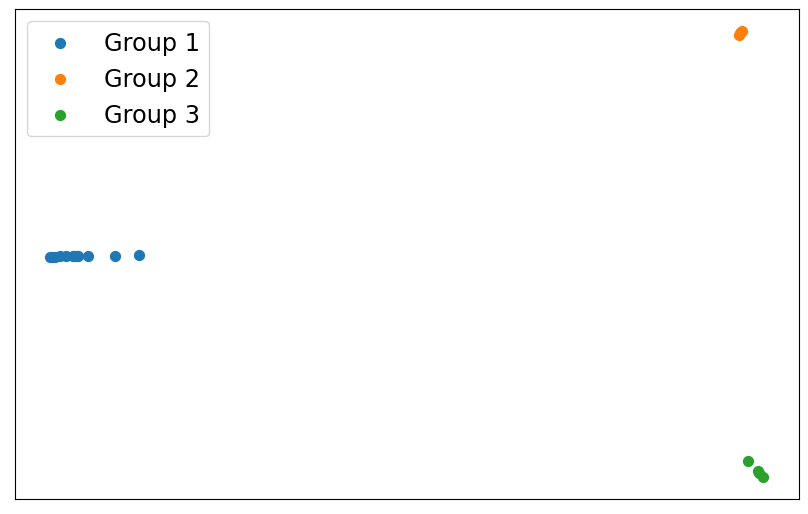

silhouette: 0.838161289691925, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
acc after global distill: 0.946, [0.963, 0.922, 0.917], 0.586
acc after cluster distill: 0.578, [0.963, 0.0, 0.0], 0.976
sever idcs: 4000
num_groups: 4
[0.4, 0.3, 0.2, 0.1]
test_data: 4000
32
Global Logit's Accuracy: 34.85%
acc before distill: 0.914, [0.944, 0.841, 0.933, 0.978], 0.47
S_normalized
[[0.73653847 0.83946186 0.8073356  0.         0.         0.
  0.         0.         0.         0.        ]
 [0.5570513  1.         0.8499157  0.         0.         0.
  0.         0.         0.         0.        ]
 [0.5711539  0.87354255 0.9000843  0.         0.         0.
  0.         0.         0.         0.        ]
 [0.6942308  0.94170403 0.7870995  0.         0.         0.
  0.         0.         0.         0.        ]
 [0.649359   0.55156946 1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.7650224  0.66905564 0.         0.        

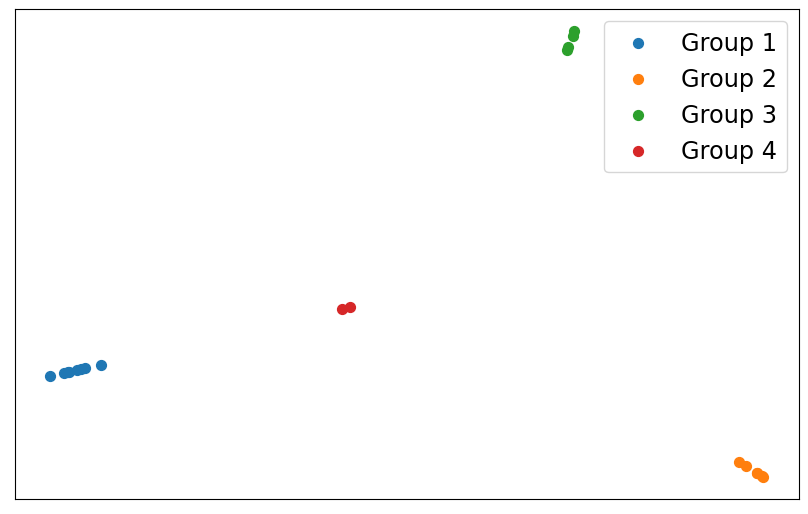

silhouette: 0.8582012057304382, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
acc after global distill: 0.932, [0.95, 0.885, 0.944, 0.978], 0.474
acc after cluster distill: 0.503, [0.947, 0.137, 0.089, 0.656], 0.975
sever idcs: 4000
num_groups: 4
[0.5, 0.2, 0.2, 0.1]
test_data: 4000
32
Global Logit's Accuracy: 29.03%
acc before distill: 0.928, [0.951, 0.917, 0.872, 0.944], 0.568
S_normalized
[[0.931853   0.53292894 0.869635   0.         0.         0.
  0.         0.         0.         0.        ]
 [0.68223584 0.81109184 0.87164056 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.92725885 0.7071057  0.7914159  0.         0.         0.
  0.         0.         0.         0.        ]
 [0.8767229  0.6490468  0.8447653  0.         0.         0.
  0.         0.         0.         0.        ]
 [0.87825423 0.64818025 0.8443642  0.         0.         0.
  0.         0.         0.         0.        ]
 [0.9854518  0.9878683  0.63096666 0.

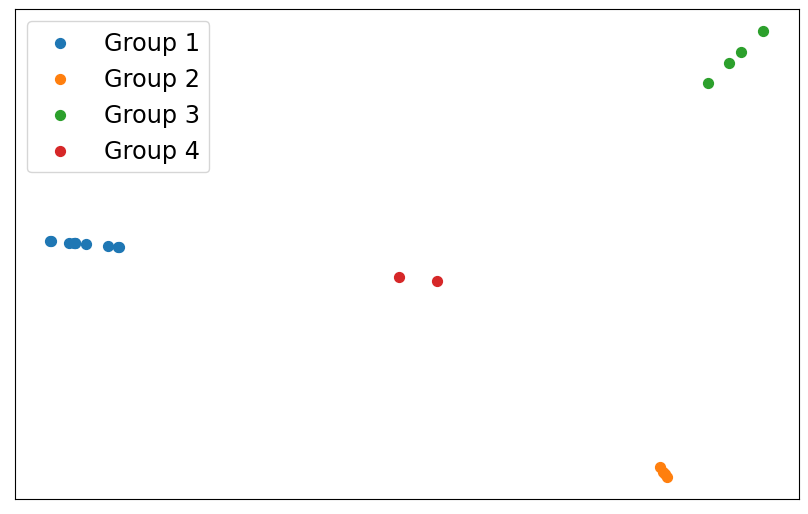

silhouette: 0.8097742199897766, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
acc after global distill: 0.944, [0.969, 0.922, 0.906, 0.944], 0.575
acc after cluster distill: 0.541, [0.951, 0.0, 0.0, 0.656], 0.978
sever idcs: 4000
num_groups: 2
[0.7, 0.3]
test_data: 4000
32
Global Logit's Accuracy: 29.20%
acc before distill: 0.906, [0.959, 0.781], 0.672
S_normalized
[[0.87548393 0.3951498  0.84030575 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.7154839  1.         0.59895414 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.4651613  0.700428   0.9239743  0.         0.         0.
  0.         0.         0.         0.        ]
 [0.5987097  0.7553495  0.8097345  0.         0.         0.
  0.         0.         0.         0.        ]
 [0.92451614 0.49857348 0.7514079  0.         0.         0.
  0.         0.         0.         0.        ]
 [0.7954839  0.6911555  0.7232502  0.         0.         0.
  0.

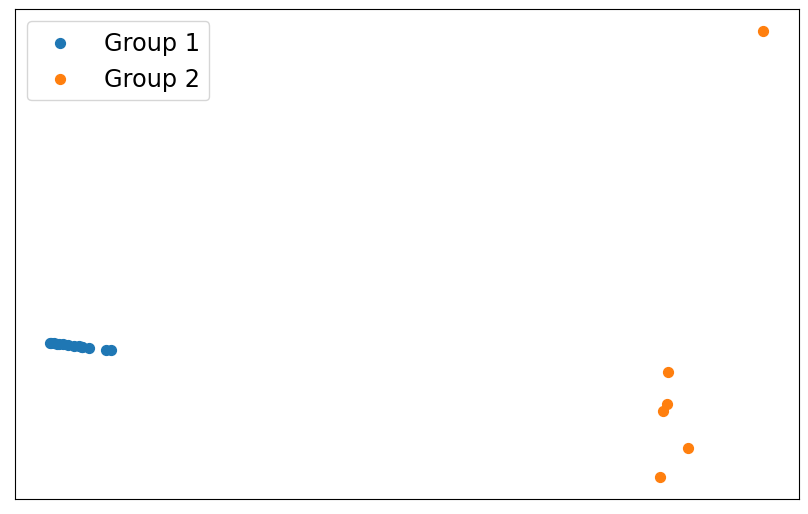

silhouette: 0.7466195225715637, ari: 1.0
client 0 distill


KeyboardInterrupt: 

In [7]:
# Define the range for t
t_values = [2]

# Initialize empty DataFrames to store results with multi-level columns
c_ds = ['type1', 'type2', 'type3', 'type4', 'type5', 'type6']
cluster_distributions = [[0.7, 0.3], [0.8, 0.2], [0.5, 0.3, 0.2], [0.6, 0.2, 0.2], [0.4, 0.3, 0.2, 0.1], [0.5, 0.2, 0.2, 0.1]]
cluster_counts = [2, 2, 3, 3, 4, 4]
n_clients = 20
class_per_cluster = 3

multi_col = pd.MultiIndex.from_product([c_ds, ['before_distill', 'global_distill', 'cluster_distill']], names=['cluster_distribution', 'Metric'])
df_client_accs = pd.DataFrame(columns=multi_col)
df_cluster_accs = pd.DataFrame(columns=multi_col)
df_global_accs = pd.DataFrame(columns=multi_col)
df_metrics = pd.DataFrame(columns=['t', 'cluster_distribution', 'Silhouette', 'ARI'])  # Added 't' here

for t in t_values:  # New loop for iterating over t
    for cluster_distribution, c_d, cluster_count in zip(cluster_distributions, c_ds, cluster_counts):
        instances_per_class_per_client = get_combination(cluster_count, class_per_cluster)
        
        # Replace with your actual cluster_train_result_exp function
        client_accs, cluster_accs, global_accs, silhouette, ari = cluster_train_result_exp(
            n_clients, 40000, 4000, cluster_count, cluster_distribution, 50, instances_per_class_per_client, t
        )

        # Update DataFrame
        experiment_key = f"{t}_{cluster_count}_{c_d}"  # Modified to include t
        df_client_accs.loc[experiment_key, (c_d, 'before_distill')] = client_accs[0]
        df_client_accs.loc[experiment_key, (c_d, 'global_distill')] = client_accs[2]
        df_client_accs.loc[experiment_key, (c_d, 'cluster_distill')] = client_accs[1]

        df_cluster_accs.loc[experiment_key, (c_d, 'before_distill')] = cluster_accs[0]
        df_cluster_accs.loc[experiment_key, (c_d, 'global_distill')] = cluster_accs[2]
        df_cluster_accs.loc[experiment_key, (c_d, 'cluster_distill')] = cluster_accs[1]

        df_global_accs.loc[experiment_key, (c_d, 'before_distill')] = global_accs[0]
        df_global_accs.loc[experiment_key, (c_d, 'global_distill')] = global_accs[2]
        df_global_accs.loc[experiment_key, (c_d, 'cluster_distill')] = global_accs[1]

        # Save silhouette and ARI
        df_metrics.loc[experiment_key, 't'] = t  # Save t value
        df_metrics.loc[experiment_key, 'cluster_distribution'] = cluster_distribution
        df_metrics.loc[experiment_key, 'Silhouette'] = silhouette
        df_metrics.loc[experiment_key, 'ARI'] = ari


In [ ]:
df_client_accs

In [ ]:
# Task 1: Rename columns 'new_cluster_distill' to 'global', and 'new_global_distill' to 'cluster'
rename_dict = {'new_cluster_distill': 'global', 'new_global_distill': 'cluster'}
df_client_accs.rename(columns=rename_dict, level='Metric', inplace=True)

# Calculate the average for each column and append it to the DataFrame
average_row = df_client_accs.mean()
df_client_accs.loc['Average'] = average_row

print(df_client_accs)


In [ ]:
# # Initialize empty DataFrames to store results with multi-level columns
# multi_col = pd.MultiIndex.from_product([range(2, 6), ['before_distill', 'global_distill', 'cluster_distill']], names=['class_per_cluster', 'Metric'])
# df_client_accs = pd.DataFrame(columns=multi_col)
# df_cluster_accs = pd.DataFrame(columns=multi_col)
# df_global_accs = pd.DataFrame(columns=multi_col)

# # Iterate over different cluster_count values
# for cluster_count in [2, 4, 6, 8, 10]:
#     # Iterate over different class_per_cluster values
#     for class_per_cluster in range(2, 6):
#         n_clients = cluster_count * 3
#         instances_per_class_per_client = get_combination(cluster_count, class_per_cluster)
#         print(instances_per_class_per_client)
#         # Replace with your actual cluster_train_result_exp function
#         client_accs, cluster_accs, global_accs = cluster_train_result_exp(
#         n_clients, 50000, 5000, cluster_count, [1/cluster_count] * cluster_count, 50, instances_per_class_per_client
#     )     
#         # Update DataFrame
#         df_client_accs.loc[cluster_count, (class_per_cluster, 'before_distill')] = client_accs[0]
#         df_client_accs.loc[cluster_count, (class_per_cluster, 'global_distill')] = client_accs[2]
#         df_client_accs.loc[cluster_count, (class_per_cluster, 'cluster_distill')] = client_accs[1]

#         df_cluster_accs.loc[cluster_count, (class_per_cluster, 'before_distill')] = cluster_accs[0]
#         df_cluster_accs.loc[cluster_count, (class_per_cluster, 'global_distill')] = cluster_accs[2]
#         df_cluster_accs.loc[cluster_count, (class_per_cluster, 'cluster_distill')] = cluster_accs[1]

#         df_global_accs.loc[cluster_count, (class_per_cluster, 'before_distill')] = global_accs[0]
#         df_global_accs.loc[cluster_count, (class_per_cluster, 'global_distill')] = global_accs[2]
#         df_global_accs.loc[cluster_count, (class_per_cluster, 'cluster_distill')] = global_accs[1]

In [ ]:
df_mean = df_client_accs.mean()
df_mean = df_mean.reset_index()
df_mean.columns = ['class_per_cluster', 'Metric', 'Value']

# Pivot the table so Metrics become columns
df_pivot = df_mean.pivot(index='class_per_cluster', columns='Metric', values='Value')

# Create a new feature
df_pivot['cluster_global_diff'] = df_pivot['cluster_distill'] - df_pivot['global_distill']

# Reset the index for the final DataFrame
df_pivot.reset_index(inplace=True)
df_pivot_filtered = df_pivot.iloc[1:]

plt.bar(df_pivot_filtered['class_per_cluster'], df_pivot_filtered['cluster_global_diff'])
plt.xlabel('Class Per Cluster')
plt.ylabel('Cluster Global Difference')
plt.title('Bar Graph of Cluster Global Difference by Class Per Cluster')
xticks = np.arange(min(df_pivot_filtered['class_per_cluster']), max(df_pivot_filtered['class_per_cluster']) + 1)
xticks = [tick for tick in xticks if tick >= 0]  # Remove negative numbers, if any
plt.xticks(xticks)

plt.show()


In [ ]:
df_global_accs

In [ ]:
def Global_TC_experiments(total_client_data, distill_data, alpha, number_of_cluster, cluster_distribution):
    print(f'number_of_cluster: {number_of_cluster}')
    data_per_class=int(distill_data//10)
    train_idcs, test_idcs = idcs[:total_client_data], idcs[total_client_data:(total_client_data + int(distill_data * 2))]
    train_labels = data.targets
    test_labels = data.targets
    
    server_idcs = generate_server_idcs(test_idcs, test_labels, int(distill_data//10))

    # client_idcs = split_noniid(train_idcs, train_labels, alpha=alpha, n_clients=N_CLIENTS)
    client_idcs, major_class_per_client = split_7plus3class_unbalanced(train_idcs, train_labels, N_CLIENTS, cluster_distribution, data_per_class_3, data_per_class_7)
    
    client_data = [CustomSubset(data, idcs) for idcs in client_idcs]
    test_data = CustomSubset(data, server_idcs, transforms.Compose([transforms.ToTensor()]))

    for i, client_datum in enumerate(client_data):
        client_datum.subset_transform = transforms.Compose([transforms.ToTensor()])

    server = Server(ConvNet, lambda x : torch.optim.Adam(x),test_data)

    clients = [Client(Representation, dat, major_class_per_client[i], i) 
           for i, dat in enumerate(client_data) if len(dat) > 20]
    
    print(f'client count: {len(clients)}')

    client_accs = []
    cluster_accs = []
    global_accs = []
    client_logits = []
    
    # # 0. Representational Learning
    # for i, client in enumerate(clients):
    #     Total_data = CustomSubset(data, np.concatenate((server_idcs, client_idcs[i])), transforms.Compose([transforms.ToTensor()]))
    #     # print(f'data used to trian representation: {len(Total_data)}')
    #     client.learn_representation(Total_data)
        
    # 1. Train classifier
    for i, client in enumerate(clients):
        client.classifier = Ten_class_classifier(client.model).to(device)
        client.train_classifier(lr=1e-3)

    client_accs, cluster_accs, global_accs = test_acc(server, clients, client_accs, cluster_accs, global_accs, cluster_distribution)
    print(f'client_acc: {client_accs[-1]}, cluster_acc: {cluster_distribution}: {cluster_accs[-1]},  global_acc: {global_accs[-1]}')
    
    # 2. get cluster loigt
    for i, client in enumerate(clients):
        client_logits.append(server.get_clients_logit(client.classifier))
    

    # 3. make global logit
    global_logits = server.get_global_logits(client_logits)
    accuracy = compute_accuracy(global_logits, test_labels, server_idcs)
    
    print(f"Global Logit's Accuracy: {accuracy * 100:.2f}%") 
    
    
     # 4. Distillation
    distill_loader = server.create_distill_loader(data, server_idcs, global_logits)
    
    for i, client in enumerate(clients):
        if i % 10 == 0:
            print(f'client {i} distill')
        client.distill(distill_loader)
    
    client_accs, cluster_accs, global_accs = test_acc(server, clients, client_accs, cluster_accs, global_accs, cluster_distribution)
    
    print(f'total_client_data: {total_client_data}, cluster_distribution: {cluster_distribution}')
    print(f'acc before distill: {client_accs[-2]}, {cluster_accs[-2]}, {global_accs[-2]}')
    print(f'last acc: {client_accs[-1]}, {cluster_accs[-1]}, {global_accs[-1]}')
    return client_accs, cluster_accs, global_accs

In [ ]:
# TC_experiments(50000, 5000, 1, 3, [1/3, 1/3, 1/3], 117, 21)

In [ ]:
clustering_by_model_experiments(50000, 5000, 1, 3, [1/3, 1/3, 1/3], 100, 0)

In [ ]:
now = datetime.datetime.now(pytz.timezone('Asia/Seoul'))
date_time = now.strftime("%m%d_%H%M")

columns = pd.MultiIndex.from_product([['client_accs', 'cluster_accs', 'global_accs'], ['before_distill', 'after_distill']],
                                     names=['acc_type', 'distill_state'])

desired_pairs = [(50000, 5000)]
cluster_distribution = [1/3, 1/3, 1/3]
experiments = ['cluster_distill', 'sim', 'global_distill']
index = pd.MultiIndex.from_product([experiments, desired_pairs], names=['experiment', 'data_pair'])

df = pd.DataFrame(index=index, columns=columns)
runs = 2  # number of times each experiment should be run

for exp in experiments:
    for pair in desired_pairs:
        total_client_accs = [0, 0]
        total_cluster_accs = [0, 0]
        total_global_accs = [0, 0]

        for _ in range(runs):
            client_data, distill_data = pair

            if exp == 'sim':
                client_accs, cluster_accs, global_accs = SimCLR_distill_experiments(client_data, distill_data, ALPHA, NUMBER_OF_CLUSTER, cluster_distribution)
            elif exp == 'global_distill':
                client_accs, cluster_accs, global_accs = global_distill_experiments(client_data, distill_data, ALPHA, NUMBER_OF_CLUSTER, cluster_distribution)
            else:
                client_accs, cluster_accs, global_accs = four_class_classification_experiments(client_data, distill_data, ALPHA, NUMBER_OF_CLUSTER, cluster_distribution)

            total_client_accs = [x+y for x, y in zip(total_client_accs, [client_accs[-2], client_accs[-1]])]
            total_cluster_accs = [x+y for x, y in zip(total_cluster_accs, [cluster_accs[-2], cluster_accs[-1]])]
            total_global_accs = [x+y for x, y in zip(total_global_accs, [global_accs[-2], global_accs[-1]])]

        avg_client_accs = [x/runs for x in total_client_accs]
        avg_cluster_accs = [x/runs for x in total_cluster_accs]
        avg_global_accs = [x/runs for x in total_global_accs]

        df.loc[(exp, pair), ('client_accs', 'before_distill')] = avg_client_accs[0]
        df.loc[(exp, pair), ('client_accs', 'after_distill')] = avg_client_accs[1]
        df.loc[(exp, pair), ('global_accs', 'before_distill')] = avg_global_accs[0]
        df.loc[(exp, pair), ('global_accs', 'after_distill')] = avg_global_accs[1]
        df.loc[(exp, pair), ('cluster_accs', 'before_distill')] = avg_cluster_accs[0]
        df.loc[(exp, pair), ('cluster_accs', 'after_distill')] = avg_cluster_accs[1]

directory = f'results/SimCLR'
if not os.path.exists(directory):
    os.makedirs(directory)
cluster_distribution_str = "_".join(map(str, cluster_distribution))
file_name = f'{directory}/client:{N_CLIENTS}_cluster:{NUMBER_OF_CLUSTER}_distribution:{cluster_distribution_str}_{date_time}.csv'
df = df.round(decimals=3)
df.to_csv(file_name)

In [ ]:
df = pd.read_csv('results/global_distill/CIFAR_0720_0435.csv', index_col=[0,1], header=[0,1])

# 그릴 데이터와 제목을 리스트로 저장
heatmap_data = [('client_accs', 'change_after_distill', 'Client Accuracy change after Distillation'),
                ('global_accs', 'change_after_distill', 'Global Accuracy change after Distillation')]

# Compute change in accuracy
df[('client_accs', 'change_after_distill')] = df[('client_accs', 'after_distill')] - df[('client_accs', 'before_distill')]
df[('global_accs', 'change_after_distill')] = df[('global_accs', 'after_distill')] - df[('global_accs', 'before_distill')]

# 전체 데이터의 최솟값, 최댓값 계산
vmin = min(df[data1][data2].min() for data1, data2, _ in heatmap_data)
vmax = max(df[data1][data2].max() for data1, data2, _ in heatmap_data)

for data1, data2, title in heatmap_data:
    plt.figure(figsize=(9, 5))
    sns.heatmap(df[(data1, data2)].unstack(), annot=True, cmap='coolwarm', center=0, vmin=-0.1, vmax=0.2)
    plt.title(title)
    plt.show()
